In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import os
import torch
!pip  install  ultralytics
from ultralytics import YOLO
import numpy as np

In [ ]:
import os
import shutil
from ultralytics import YOLO

def track_single_video_to_output(
    model,
    input_video_path,
    output_dir,
    tracker="botsort.yaml",
    conf=0.25,
    imgsz=640,
    device="0"
):
    """
    Track objects in a video with YOLO and save the output.

    Args:
        model (YOLO): Trained YOLO model.
        input_video_path (str): Path to input video.
        output_dir (str): Folder to save the output .avi file.
        tracker (str): Tracker type (e.g., "botsort.yaml", "bytetrack.yaml").
        conf (float): Detection confidence threshold.
        imgsz (int): Image size for YOLO inference.
        device (str): "cpu" or GPU index (e.g., "0").
    """
    video_name = os.path.basename(input_video_path)
    print(f"\n📹 Tracking: {video_name}")

    # Run tracking
    results = model.track(
        source=input_video_path,
        conf=conf,
        imgsz=imgsz,
        save=True,
        save_txt=True,      # save label txt files with bbox + track id
        project='runs/track',
        name='compression_track',
        tracker=tracker,
        device=device,
        verbose=False,
        stream=True
    )

    save_dir = results[0].save_dir
    predicted_file = os.path.join(save_dir, os.path.splitext(video_name)[0] + ".avi")
    output_path = os.path.join(output_dir, os.path.basename(predicted_file))

    os.makedirs(output_dir, exist_ok=True)

    # Copy output video
    if os.path.exists(predicted_file):
        shutil.copy2(predicted_file, output_path)
        print(f"✅ Saved to: {output_path}")
    else:
        print(f"⚠️ Tracked video not found: {predicted_file}")

    # Tracking labels saved in: runs/track/compression_track/labels/
    label_dir = os.path.join(save_dir, "labels")
    return label_dir

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Force visibility for Ultralytics

import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())

CUDA available: True
CUDA device count: 1


In [ ]:
model = YOLO(YOLO_WEIGHTS_PATH) # Load YOLOv8 model
label_dir = track_single_video_to_output(model, VIDEO_PATH, OUTPUT_DIR)


📹 Tracking: 3.7.25_sc7_chest_compression.mp4
WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

WARNING ⚠️ NMS time limit 2.050s exceeded
WARNING ⚠️ NMS time limit 2.050s exceeded
WARNING ⚠️ NMS time limit 2.050s exceeded



KeyboardInterrupt



In [ ]:
# Install required libraries
!pip install ultralytics opencv-python matplotlib scipy

# Import necessary libraries
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from ultralytics import YOLO
from google.colab import files
import io
import time
from IPython.display import HTML, display, clear_output
from base64 import b64encode

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
YOLO_WEIGHTS_PATH = '/content/drive/MyDrive/6.7930/best_yolo_weights_across_skin_colors.pt'
VIDEO_PATH = '/content/drive/MyDrive/6.7930/Chest Compressions/Yes/3.7.25_sc7_chest_compression.mp4'
OUTPUT_PATH = '/content/drive/MyDrive/6.7930/Chest Compressions/output.mp4'
# os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
class ChestCompressionDetector:
    def __init__(self, model_weights_path = YOLO_WEIGHTS_PATH, compression_rate=90, window_size=60):
        """
        Initialize the chest compression detector

        Args:
            model_weights_path: Path to YOLOv8 weights file
            compression_rate: Expected compressions per minute (default 90)
            window_size: Number of frames to analyze for rhythm detection
        """
        # Load the YOLO model with the provided weights
        self.model = YOLO(model_weights_path)

        # Parameters for chest compression detection
        self.expected_rate = compression_rate  # 90 compressions per minute
        self.window_size = window_size  # Frames to analyze for rhythm
        self.compression_history = []  # Store motion values for analysis

        # Parameters for optical flow
        self.prev_frame = None
        self.prev_gray = None

        # Initialize detection state
        self.compression_active = False
        self.roi = None  # Region of interest (where chest/thumbs are detected)

    def detect_roi(self, frame):
        """Detect the region of interest using YOLOv8"""
        results = self.model(frame)

        # Extract bounding boxes for the detected objects
        boxes = []
        for result in results:
            for box in result.boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                conf = box.conf[0].cpu().numpy()
                cls = int(box.cls[0].cpu().numpy())

                # Filter by class and confidence if needed
                boxes.append((x1, y1, x2, y2, conf, cls))

        # If relevant objects are detected, define the ROI
        if boxes:
            # Simple approach: take the highest confidence detection
            boxes.sort(key=lambda x: x[4], reverse=True)
            x1, y1, x2, y2, conf, cls = boxes[0]

            # You might want to filter by class here or merge multiple detections
            self.roi = (x1, y1, x2, y2)
            return True

        return False

    def compute_optical_flow(self, frame):
        """Compute optical flow in the ROI"""
        if self.roi is None:
            return False, None

        # Extract the ROI
        x1, y1, x2, y2 = self.roi
        roi_frame = frame[y1:y2, x1:x2]

        # Convert to grayscale
        gray = cv2.cvtColor(roi_frame, cv2.COLOR_BGR2GRAY)

        # Initialize optical flow
        if self.prev_gray is None:
            self.prev_gray = gray
            return False, None

        # Calculate optical flow (Farneback)
        flow = cv2.calcOpticalFlowFarneback(
            self.prev_gray, gray,
            None, 0.5, 3, 15, 3, 5, 1.2, 0
        )

        # Update previous frame
        self.prev_gray = gray

        return True, flow

    def analyze_motion(self, flow):
        """Analyze motion to detect rhythmic compression patterns"""
        if flow is None:
            return 0, False

        # Calculate the magnitude of motion
        magnitude = np.sqrt(flow[..., 0]**2 + flow[..., 1]**2)

        # Focus on vertical motion (y-component more relevant for compressions)
        vertical_motion = np.mean(np.abs(flow[..., 1]))

        # Add to history
        self.compression_history.append(vertical_motion)

        # Keep history to a fixed window size
        if len(self.compression_history) > self.window_size:
            self.compression_history.pop(0)

        # If we have enough history, analyze for rhythmic patterns
        if len(self.compression_history) >= self.window_size:
            return self.detect_rhythm()

        return vertical_motion, False

    def detect_rhythm(self):
        """Detect if the motion follows a rhythmic pattern consistent with chest compressions"""
        # Get the motion history array
        motion_array = np.array(self.compression_history)

        # Find peaks in the motion (compressions)
        peaks, _ = find_peaks(motion_array, height=0.1, distance=3)

        # If we have enough peaks, calculate the rhythm
        if len(peaks) > 3:
            # Calculate time between peaks (assuming fixed frame rate)
            peak_intervals = np.diff(peaks)
            avg_interval = np.mean(peak_intervals)

            # Calculate compressions per minute
            # Assuming 30 fps as an example
            fps = 30
            compressions_per_minute = (fps * 60) / avg_interval

            # Check if the rhythm matches expected compression rate (with tolerance)
            is_compression = (
                abs(compressions_per_minute - self.expected_rate) < 15 and
                np.std(peak_intervals) < avg_interval * 0.3  # Check consistency
            )

            current_motion = motion_array[-1]
            return current_motion, is_compression

        return motion_array[-1], False

    def process_frame(self, frame):
        """Process a single frame to detect chest compressions"""
        # Check if ROI already exists, if not try to detect it
        if self.roi is None:
            roi_detected = self.detect_roi(frame)
            if not roi_detected:
                return frame, False, 0

        # Periodically update ROI (every 30 frames for example)
        if np.random.randint(0, 30) == 0:
            self.detect_roi(frame)

        # Compute optical flow
        flow_success, flow = self.compute_optical_flow(frame)

        if not flow_success:
            return frame, False, 0

        # Analyze motion to detect compressions
        motion_value, is_compression = self.analyze_motion(flow)

        # Update compression state
        if is_compression and motion_value > 0.2:  # Threshold to filter small motions
            self.compression_active = True
        elif motion_value < 0.1:  # Low motion threshold to detect end
            self.compression_active = False

        # Visualize detection on frame
        if self.roi:
            x1, y1, x2, y2 = self.roi
            color = (0, 255, 0) if self.compression_active else (0, 0, 255)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

            # Add text indicating compression status
            status = "COMPRESSION ACTIVE" if self.compression_active else "NO COMPRESSION"
            cv2.putText(frame, status, (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

            # Add motion value
            cv2.putText(frame, f"Motion: {motion_value:.2f}", (x1, y2+20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        return frame, self.compression_active, motion_value

    def process_video(self, video_path, output_path=None, display_in_notebook=True):
        """Process entire video and detect chest compressions"""
        cap = cv2.VideoCapture(video_path)

        # Get video properties
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))

        # Set up output video writer if needed
        writer = None
        if output_path:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        # For plotting motion over time
        motion_values = []
        compression_states = []

        # For displaying in notebook
        if display_in_notebook:
            # Create a placeholder for the output
            display_id = display(HTML("Processing video..."), display_id=True)
            last_update = time.time()

        frame_count = 0
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Process the frame
            processed_frame, is_compression, motion_value = self.process_frame(frame)

            # Store results for plotting
            motion_values.append(motion_value)
            compression_states.append(1 if is_compression else 0)

            # Write to output video
            if writer:
                writer.write(processed_frame)

            # Display in notebook (update every 1 second to avoid slowdown)
            if display_in_notebook and time.time() - last_update > 1:
                # Convert the frame to JPEG
                _, buffer = cv2.imencode('.jpg', processed_frame)
                # Convert to base64
                b64_img = b64encode(buffer).decode('utf-8')
                # Create an HTML img tag
                img_html = f'<img src="data:image/jpeg;base64,{b64_img}" width="640" />'
                # Update the display
                progress = (frame_count / total_frames) * 100 if total_frames > 0 else 0
                display_id.update(HTML(f'<p>Progress: {progress:.1f}%</p>{img_html}'))
                last_update = time.time()

            frame_count += 1

        # Release resources
        cap.release()
        if writer:
            writer.release()

        # Plot the motion values and compression states
        self.plot_results(motion_values, compression_states)

        # Save and download output if needed
        if output_path and display_in_notebook:
            files.download(output_path)

        return motion_values, compression_states

    def plot_results(self, motion_values, compression_states):
        """Plot the motion values and compression states"""
        plt.figure(figsize=(12, 6))

        # Plot motion values
        plt.subplot(2, 1, 1)
        plt.plot(motion_values)
        plt.title('Vertical Motion')
        plt.ylabel('Motion Magnitude')

        # Plot compression states
        plt.subplot(2, 1, 2)
        plt.plot(compression_states)
        plt.title('Compression Detection')
        plt.xlabel('Frame')
        plt.ylabel('Compression Active')
        plt.ylim(-0.1, 1.1)

        plt.tight_layout()
        plt.savefig('compression_analysis.png')
        plt.show()

        # Download the plot
        files.download('compression_analysis.png')


In [ ]:
# Install required libraries
!pip install ultralytics opencv-python matplotlib scipy

# Import necessary libraries
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from ultralytics import YOLO
import io
import time
from IPython.display import HTML, display, clear_output
from base64 import b64encode
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

class ChestCompressionDetector:
    def __init__(self, model_weights_path, compression_rate=90, window_size=60):
        """
        Initialize the chest compression detector

        Args:
            model_weights_path: Path to YOLOv8 weights file
            compression_rate: Expected compressions per minute (default 90)
            window_size: Number of frames to analyze for rhythm detection
        """
        # Load the YOLO model with the provided weights
        self.model = YOLO(model_weights_path)

        # Parameters for chest compression detection
        self.expected_rate = compression_rate  # 90 compressions per minute
        self.window_size = window_size  # Frames to analyze for rhythm
        self.compression_history = []  # Store motion values for analysis

        # Parameters for optical flow
        self.prev_gray = None
        self.stabilized_roi = None  # A fixed-size ROI for optical flow
        self.roi_padding = 10  # Padding around detection to maintain stable size

        # Initialize detection state
        self.compression_active = False
        self.roi = None  # Region of interest (where chest/thumbs are detected)

        # Initialize counters for state machine
        self.active_frame_count = 0
        self.inactive_frame_count = 0

        # For tracking compression duration
        self.continuous_compression_frames = 0
        self.min_compression_duration_frames = 0  # Will be set based on FPS
        self.fps = 30  # Default, will be updated with actual FPS
        self.valid_compression = False  # True only after minimum duration

    def set_fps(self, fps):
        """Set the frames per second for timing calculations"""
        self.fps = fps
        # For 10 seconds at given FPS --> 90 compressions / sec --> 15 compressions
        self.min_compression_duration_frames = int(10 * fps)
        print(f"Set FPS to {fps}, minimum compression duration: {self.min_compression_duration_frames} frames")

    def detect_roi(self, frame):
        """Detect the region of interest using YOLOv8"""
        try:
            results = self.model(frame)

            # Extract bounding boxes for the detected objects
            boxes = []
            for result in results:
                for box in result.boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                    conf = box.conf[0].cpu().numpy()
                    cls = int(box.cls[0].cpu().numpy())

                    boxes.append((x1, y1, x2, y2, conf, cls))

            # If relevant objects are detected, define the ROI
            if boxes:
                # Take the highest confidence detection
                boxes.sort(key=lambda x: x[4], reverse=True)
                x1, y1, x2, y2, conf, cls = boxes[0]

                # Ensure ROI is within frame boundaries
                h, w = frame.shape[:2]
                x1, x2 = max(0, x1), min(w, x2)
                y1, y2 = max(0, y1), min(h, y2)

                # Create a more stable ROI with padding
                center_x = (x1 + x2) // 2
                center_y = (y1 + y2) // 2
                width = x2 - x1 + 2 * self.roi_padding
                height = y2 - y1 + 2 * self.roi_padding

                # Initialize stabilized ROI if first detection
                if self.stabilized_roi is None:
                    self.stabilized_roi = (width, height)
                else:
                    # Smooth transition to new size (avoid sudden changes)
                    stable_w, stable_h = self.stabilized_roi
                    width = int(0.9 * stable_w + 0.1 * width)
                    height = int(0.9 * stable_h + 0.1 * height)
                    self.stabilized_roi = (width, height)

                # Calculate fixed-size ROI around center
                half_width = width // 2
                half_height = height // 2
                x1 = max(0, center_x - half_width)
                y1 = max(0, center_y - half_height)
                x2 = min(w, center_x + half_width)
                y2 = min(h, center_y + half_height)

                # Ensure minimum ROI size
                if x2 - x1 < 10 or y2 - y1 < 10:
                    if self.roi is None:  # Only print once
                        print("ROI too small, using default region")
                    return False

                self.roi = (x1, y1, x2, y2)
                return True

            return False

        except Exception as e:
            print(f"Error in detect_roi: {e}")
            return False

    def compute_optical_flow(self, frame):
        """Compute optical flow in the ROI and return flow with visualization"""
        if self.roi is None:
            return False, None, None

        try:
            # Extract the ROI
            x1, y1, x2, y2 = self.roi
            roi_frame = frame[y1:y2, x1:x2]

            # Ensure ROI frame has valid dimensions
            if roi_frame.size == 0 or roi_frame.shape[0] < 2 or roi_frame.shape[1] < 2:
                print(f"Invalid ROI dimensions: {roi_frame.shape}")
                return False, None, None

            # Convert to grayscale
            gray = cv2.cvtColor(roi_frame, cv2.COLOR_BGR2GRAY)

            # Apply fixed resize to ensure consistent dimensions for optical flow
            target_size = (150, 150)  # Fixed size for optical flow
            gray = cv2.resize(gray, target_size)

            # Initialize optical flow
            if self.prev_gray is None:
                self.prev_gray = gray
                return False, None, None

            # Calculate optical flow (Farneback)
            flow = cv2.calcOpticalFlowFarneback(
                self.prev_gray, gray,
                None, 0.5, 3, 15, 3, 5, 1.2, 0
            )

            # Create flow visualization
            flow_vis = self.draw_flow(gray, flow)

            # Update previous frame
            self.prev_gray = gray
            return True, flow, flow_vis

        except Exception as e:
            print(f"Error in compute_optical_flow: {e}")
            self.prev_gray = None  # Reset for next frame
            return False, None, None

    def draw_flow(self, img, flow, step=8):
        """Draw optical flow arrows on image"""
        h, w = img.shape[:2]
        y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
        fx, fy = flow[y, x].T

        # Create visualization image
        vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        # Draw arrows
        lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
        lines = np.int32(lines)

        # Draw a background for better visibility of arrows
        cv2.rectangle(vis, (0, 0), (w, h), (64, 64, 64), -1)

        # Draw title
        cv2.putText(vis, "Optical Flow", (5, 15),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        # Color based on motion magnitude and direction
        for (x1, y1), (x2, y2) in lines:
            dx, dy = x2-x1, y2-y1
            magnitude = np.sqrt(dx*dx + dy*dy)

            # Skip very small motions
            if magnitude < 1:
                continue

            # Color based on direction (red for upward, blue for downward)
            if dy < 0:  # Upward motion (positive vertical in image coordinates is downward)
                color = (0, 0, 255)  # Red for upward (recoil)
            else:
                color = (255, 0, 0)  # Blue for downward (compression)

            cv2.arrowedLine(vis, (x1, y1), (x2, y2), color, 1, tipLength=0.3)

        # Draw legend
        cv2.putText(vis, "Compression", (5, h-25),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)
        cv2.putText(vis, "Recoil", (5, h-10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 255), 1)

        # Draw a frame around the visualization
        cv2.rectangle(vis, (0, 0), (w-1, h-1), (255, 255, 255), 1)

        return vis

    def analyze_motion(self, flow):
        """Analyze motion to detect rhythmic compression patterns"""
        if flow is None:
            return 0, False

        try:
            # Calculate vertical motion (y-component more relevant for compressions)
            vertical_motion = np.mean(np.abs(flow[..., 1]))

            # Add to history
            self.compression_history.append(vertical_motion)

            # Keep history to a fixed window size
            if len(self.compression_history) > self.window_size:
                self.compression_history.pop(0)

            # If we have enough history, analyze for rhythmic patterns
            if len(self.compression_history) >= self.window_size // 2:  # Reduced requirement
                return self.detect_rhythm()

            return vertical_motion, False

        except Exception as e:
            print(f"Error in analyze_motion: {e}")
            return 0, False

    def detect_rhythm(self):
        """Detect if the motion follows a rhythmic pattern consistent with chest compressions"""
        try:
            # Get the motion history array
            motion_array = np.array(self.compression_history)

            # If not enough variation in motion, return false
            if np.max(motion_array) - np.min(motion_array) < 0.05:
                return motion_array[-1], False

            # Normalize the motion array for better peak detection
            norm_motion = (motion_array - np.min(motion_array)) / (np.max(motion_array) - np.min(motion_array) + 1e-6)

            # Parameters tuned for chest compression pattern
            # Find peaks in the motion (compressions)
            peaks, properties = find_peaks(
                norm_motion,
                height=0.3,       # Peak threshold
                distance=5,       # Minimum distance between peaks
                prominence=0.2    # Minimum prominence
            )

            # If we have enough peaks, calculate the rhythm
            if len(peaks) >= 3:  # Need at least 3 peaks to calculate rhythm
                # Calculate time between peaks
                peak_intervals = np.diff(peaks)
                avg_interval = np.mean(peak_intervals)

                # Assume 30 fps for rhythm calculation
                fps = self.fps
                compressions_per_minute = (fps * 60) / avg_interval

                # Check rhythm against expected rate (90 per min)
                is_rhythm = (
                    abs(compressions_per_minute - self.expected_rate) < 15 and  # Tolerance of 15 bpm
                    np.std(peak_intervals) / avg_interval < 0.3                # Consistency check
                )

                # Print debugging info occasionally
                if np.random.randint(0, 30) == 0:
                    print(f"Peaks: {len(peaks)}, Rate: {compressions_per_minute:.1f} bpm, " +
                         f"Consistency: {np.std(peak_intervals) / avg_interval:.2f}, Rhythm: {is_rhythm}")

                return motion_array[-1], is_rhythm

            return motion_array[-1], False

        except Exception as e:
            print(f"Error in detect_rhythm: {e}")
            return 0, False

    def process_frame(self, frame):
        """Process a single frame to detect chest compressions"""
        try:
            # Make a copy of the frame to avoid modifying the original
            display_frame = frame.copy()

            # Check if ROI already exists, if not try to detect it
            if self.roi is None:
                roi_detected = self.detect_roi(frame)
                if not roi_detected:
                    # Reset compression state if ROI lost
                    self.compression_active = False
                    self.continuous_compression_frames = 0
                    self.valid_compression = False
                    return display_frame, False, 0

            # Periodically update ROI
            if np.random.randint(0, 30) == 0:
                self.detect_roi(frame)

            # Compute optical flow
            flow_success, flow, flow_vis = self.compute_optical_flow(frame)

            if not flow_success:
                # Reset compression state if flow calculation fails
                self.compression_active = False
                self.continuous_compression_frames = 0
                self.valid_compression = False
                return display_frame, False, 0

            # Analyze motion to detect compressions
            motion_value, is_rhythm = self.analyze_motion(flow)

            # Fine-tuned thresholds based on testing
            high_threshold = 0.15   # Motion activation threshold
            low_threshold = 0.05    # Motion deactivation threshold

            # Update state counters with balanced logic
            if motion_value > high_threshold:
                # Increase active counter, faster if rhythm detected
                if is_rhythm:
                    self.active_frame_count += 2
                else:
                    self.active_frame_count += 1
                self.inactive_frame_count = max(0, self.inactive_frame_count - 1)
            elif motion_value < low_threshold:
                self.inactive_frame_count += 1
                self.active_frame_count = max(0, self.active_frame_count - 1)

            # Limit counters
            self.active_frame_count = min(10, self.active_frame_count)
            self.inactive_frame_count = min(10, self.inactive_frame_count)

            # Apply state change with appropriate thresholds
            required_active_frames = 4     # Frames required to activate
            required_inactive_frames = 6   # Frames required to deactivate

            # Update compression_active state
            prev_state = self.compression_active

            if self.active_frame_count >= required_active_frames:
                self.compression_active = True
            elif self.inactive_frame_count >= required_inactive_frames:
                self.compression_active = False

            # Track continuous compression duration
            if self.compression_active:
                self.continuous_compression_frames += 1
            else:
                # Reset the counter when compression stops
                self.continuous_compression_frames = 0
                self.valid_compression = False

            # Check if we've reached the minimum duration (5 seconds)
            if self.continuous_compression_frames >= self.min_compression_duration_frames:
                self.valid_compression = True

            # Calculate seconds of continuous compression
            compression_seconds = self.continuous_compression_frames / self.fps

            # Visualize on frame
            if self.roi:
                x1, y1, x2, y2 = self.roi

                # Different colors based on compression state and validity
                if self.valid_compression:
                    color = (0, 255, 0)  # Green for valid compression (>5 sec)
                elif self.compression_active:
                    color = (0, 255, 255)  # Yellow for active but not yet valid
                else:
                    color = (0, 0, 255)  # Red for inactive

                # Draw ROI rectangle
                cv2.rectangle(display_frame, (x1, y1), (x2, y2), color, 2)

                # Add optical flow visualization to top-right corner of frame
                if flow_vis is not None:
                    h, w = flow_vis.shape[:2]
                    # Position in top-right corner with 10px margin
                    display_frame[10:10+h, display_frame.shape[1]-w-10:display_frame.shape[1]-10] = flow_vis

                # Add text indicating compression status
                if self.valid_compression:
                    status = f"VALID COMPRESSION ({compression_seconds:.1f}s)"
                elif self.compression_active:
                    status = f"COMPRESSION ACTIVE ({compression_seconds:.1f}s / {10}.0s)"
                else:
                    status = "NO COMPRESSION"

                cv2.putText(display_frame, status, (x1, y1-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

                # Add motion value and counters
                cv2.putText(display_frame, f"Motion: {motion_value:.2f}", (x1, y2+20),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
                cv2.putText(display_frame, f"Active:{self.active_frame_count}/{required_active_frames} " +
                           f"Inactive:{self.inactive_frame_count}/{required_inactive_frames}",
                          (x1, y2+40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

            return display_frame, self.valid_compression, motion_value

        except Exception as e:
            print(f"Error in process_frame: {e}")
            return frame, False, 0

    def process_video(self, video_path, output_path=None, display_in_notebook=True):
        """Process entire video and detect chest compressions"""
        # Check if video file exists
        if not os.path.exists(video_path):
            print(f"Error: Video file not found at {video_path}")
            return [], []

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video file {video_path}")
            return [], []

        # Get video properties
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        print(f"Video dimensions: {width}x{height}, FPS: {fps}")

        # Set FPS for duration calculations
        self.set_fps(fps)

        # Set up output video writer if needed
        writer = None
        if output_path:
            # Ensure output directory exists
            output_dir = os.path.dirname(output_path)
            if output_dir and not os.path.exists(output_dir):
                os.makedirs(output_dir, exist_ok=True)

            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        # For plotting motion over time
        motion_values = []
        compression_states = []

        # For displaying in notebook
        if display_in_notebook:
            # Create a placeholder for the output
            display_id = display(HTML("Processing video..."), display_id=True)
            last_update = time.time()

        frame_count = 0
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f"Total frames: {total_frames}")

        # Process frames
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Process the frame
            processed_frame, is_compression, motion_value = self.process_frame(frame)

            # Store results for plotting
            motion_values.append(motion_value)
            compression_states.append(1 if is_compression else 0)

            # Write to output video
            if writer:
                writer.write(processed_frame)

            # Display in notebook (update every 1 second to avoid slowdown)
            if display_in_notebook and time.time() - last_update > 1:
                # Convert the frame to JPEG
                _, buffer = cv2.imencode('.jpg', processed_frame)
                # Convert to base64
                b64_img = b64encode(buffer).decode('utf-8')
                # Create an HTML img tag
                img_html = f'<img src="data:image/jpeg;base64,{b64_img}" width="640" />'
                # Update the display
                progress = (frame_count / total_frames) * 100 if total_frames > 0 else 0
                display_id.update(HTML(f'<p>Progress: {progress:.1f}%</p>{img_html}'))
                last_update = time.time()

            frame_count += 1

            # Print progress every 100 frames
            if frame_count % 100 == 0:
                print(f"Processed {frame_count}/{total_frames} frames ({frame_count/total_frames*100:.1f}%)")

            # # Break early for testing (process only first 10 seconds at 30fps)
            # # Remove this line for full video processing
            # if frame_count > 1800:  # Increased to 60 seconds for better analysis
            #     print("Processed first 1800 frames (~60s). Remove the frame limit for full processing.")
            #     break

        # Release resources
        cap.release()
        if writer:
            writer.release()

        # Plot the motion values and compression states
        if len(motion_values) > 0:
            self.plot_results(motion_values, compression_states)

        print(f"Processing complete! Output saved to {output_path}")
        return motion_values, compression_states

    def plot_results(self, motion_values, compression_states):
        """Plot the motion values and compression states"""
        try:
            plt.figure(figsize=(12, 8))

            # Plot motion values
            plt.subplot(2, 1, 1)
            plt.plot(motion_values)
            plt.title('Vertical Motion')
            plt.ylabel('Motion Magnitude')
            plt.grid(True)

            # Highlight compression regions
            for i, is_active in enumerate(compression_states):
                if is_active:
                    plt.axvspan(i-0.5, i+0.5, color='green', alpha=0.3)

            # Plot compression states
            plt.subplot(2, 1, 2)
            plt.plot(compression_states)
            plt.title('Valid Compression Detection (>5 seconds)')
            plt.xlabel('Frame')
            plt.ylabel('Compression Active')
            plt.ylim(-0.1, 1.1)
            plt.grid(True)

            plt.tight_layout()
            plot_path = '/content/drive/MyDrive/compression_analysis.png'
            plt.savefig(plot_path)
            plt.show()

            print(f"Plot saved to {plot_path}")

        except Exception as e:
            print(f"Error in plot_results: {e}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using model weights: /content/drive/MyDrive/6.7930/best_yolo_weights_across_skin_colors.pt
Processing video: /content/drive/MyDrive/6.7930/Chest Compressions/Yes/3.7.25_sc7_chest_compression.mp4
Output will be saved to: /content/drive/MyDrive/6.7930/Chest Compressions/output.mp4
Video dimensions: 1280x720, FPS: 29
Set FPS to 29, minimum compression duration: 290 frames



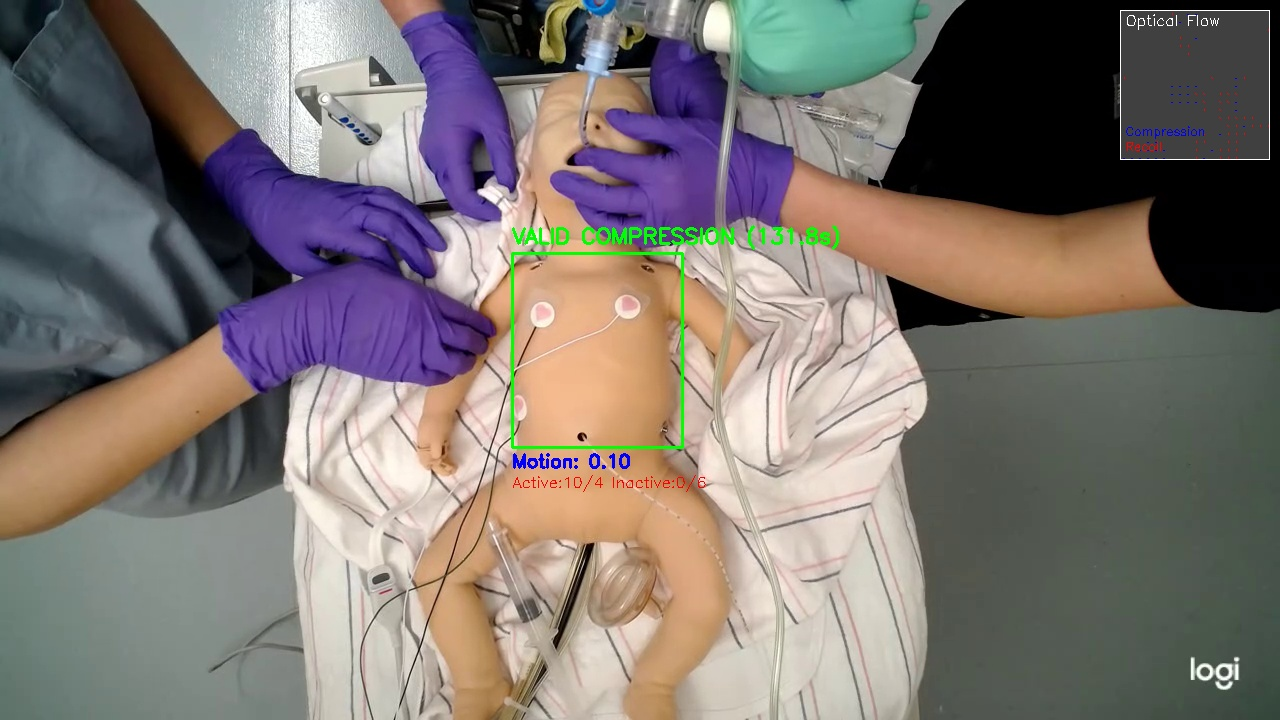

Total frames: 6234

0: 384x640 1 torso, 143.1ms
Speed: 1.9ms preprocess, 143.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 torso, 159.6ms
Speed: 1.7ms preprocess, 159.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 torso, 161.7ms
Speed: 2.3ms preprocess, 161.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Peaks: 4, Rate: 186.4 bpm, Consistency: 0.05, Rhythm: False
Peaks: 4, Rate: 186.4 bpm, Consistency: 0.05, Rhythm: False
Peaks: 4, Rate: 106.5 bpm, Consistency: 0.46, Rhythm: False

0: 384x640 1 torso, 155.4ms
Speed: 2.0ms preprocess, 155.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 torso, 184.4ms
Speed: 11.6ms preprocess, 184.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 torso, 120.0ms
Speed: 2.1ms preprocess, 120.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 torso, 184.5ms
Speed: 2.

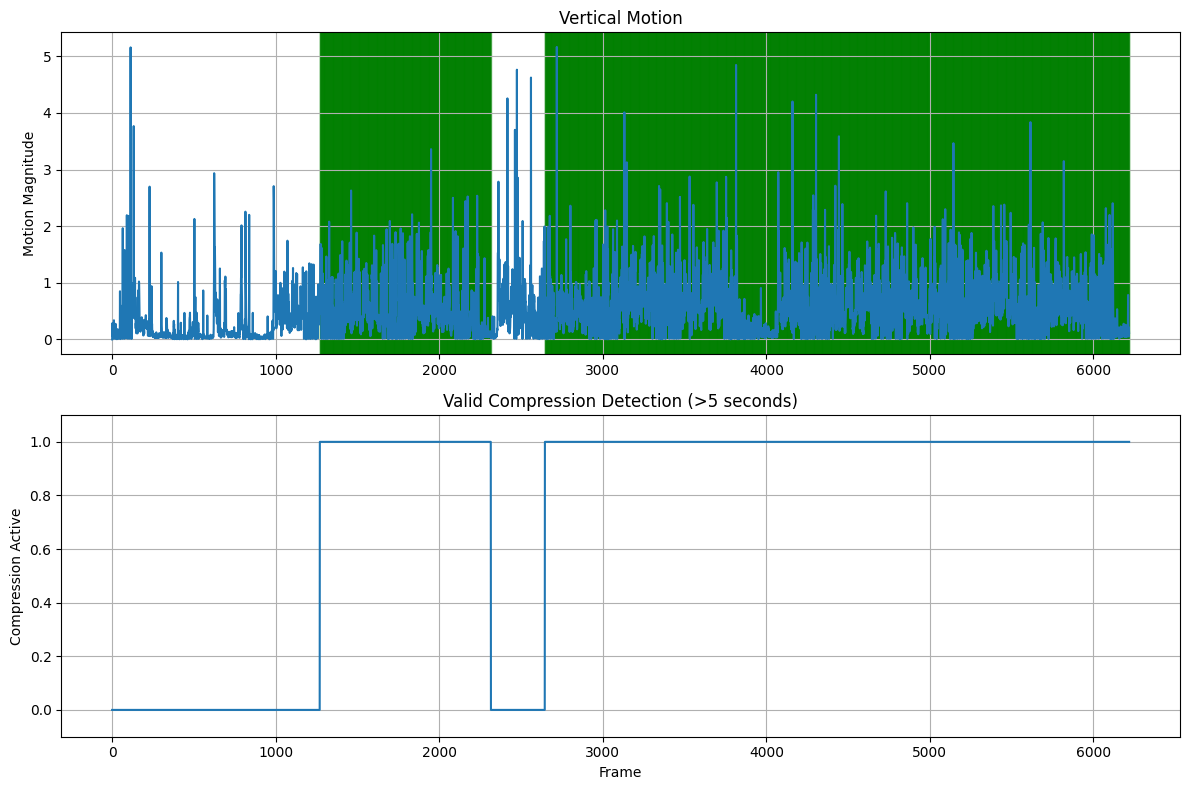

Plot saved to /content/drive/MyDrive/compression_analysis.png
Processing complete! Output saved to /content/drive/MyDrive/6.7930/Chest Compressions/output.mp4


In [ ]:
# Main execution function for using files from Google Drive
def main_from_drive():
    # Paths to files in Google Drive
    model_weights_path = YOLO_WEIGHTS_PATH  # Update this path
    video_path = VIDEO_PATH  # Update this path
    output_path = OUTPUT_PATH  # Output location

    print(f"Using model weights: {model_weights_path}")
    print(f"Processing video: {video_path}")
    print(f"Output will be saved to: {output_path}")

    # Check if files exist
    if not os.path.exists(model_weights_path):
        print(f"Error: Model weights file not found at {model_weights_path}")
        return

    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return

    # Initialize the detector
    detector = ChestCompressionDetector(
        model_weights_path=model_weights_path,
        compression_rate=90  # 90 compressions per minute as specified
    )

    # Process the video
    detector.process_video(
        video_path=video_path,
        output_path=output_path,
        display_in_notebook=True
    )

# Run the main function for Google Drive
if __name__ == "__main__":
    main_from_drive()

In [ ]:
OUTPUT_PATH

'/content/drive/MyDrive/6.7930/Chest Compressions/output.mp4'

Using model weights: /content/drive/MyDrive/6.7930/best_yolo_weights_across_skin_colors.pt
Processing video: /content/drive/MyDrive/6.7930/Chest Compressions/Yes/2025-04-17_12-11-39_chest_compression.mp4
Output will be saved to: /content/drive/MyDrive/6.7930/Chest Compressions/output2.mp4
Video dimensions: 1280x720, FPS: 29
Set FPS to 29, minimum compression duration: 290 frames



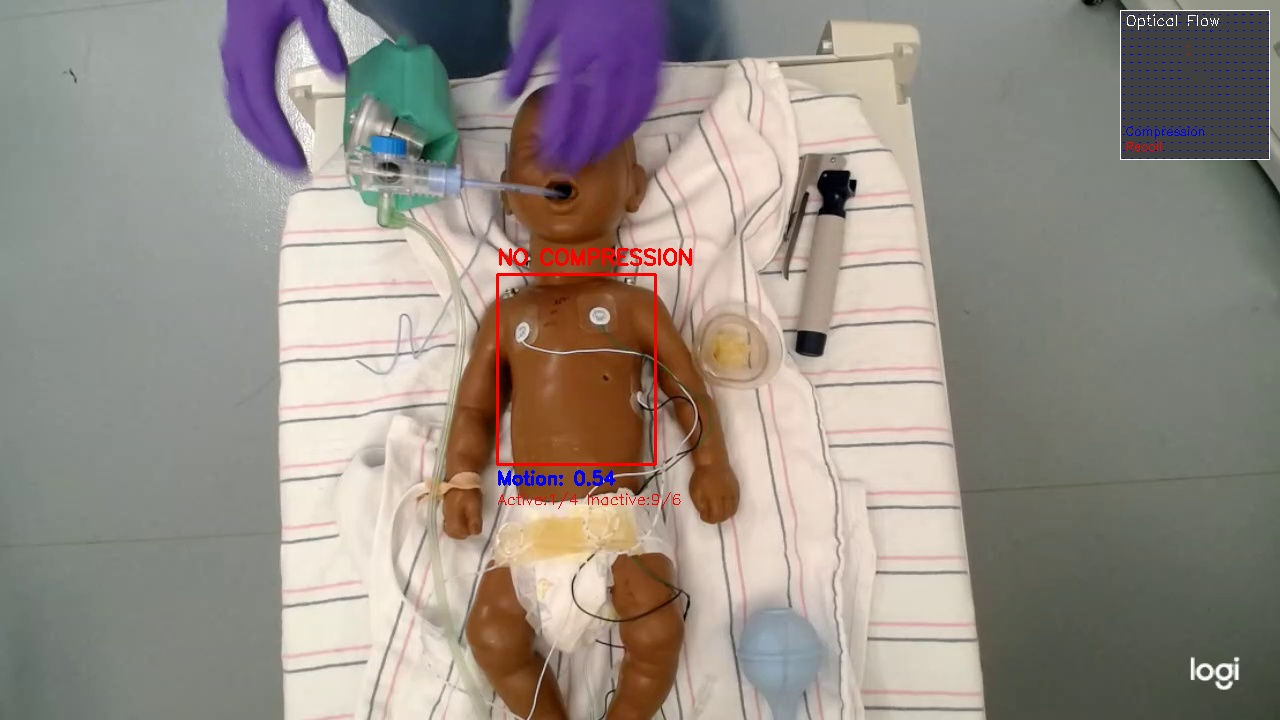

Total frames: 1435

0: 384x640 1 torso, 93.0ms
Speed: 2.5ms preprocess, 93.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 torso, 96.7ms
Speed: 2.3ms preprocess, 96.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)
Peaks: 4, Rate: 208.8 bpm, Consistency: 0.30, Rhythm: False
Peaks: 4, Rate: 208.8 bpm, Consistency: 0.30, Rhythm: False
Peaks: 5, Rate: 232.0 bpm, Consistency: 0.35, Rhythm: False

0: 384x640 1 torso, 95.7ms
Speed: 1.9ms preprocess, 95.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 torso, 101.6ms
Speed: 1.8ms preprocess, 101.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
Peaks: 6, Rate: 217.5 bpm, Consistency: 0.32, Rhythm: False

0: 384x640 1 torso, 95.9ms
Speed: 1.9ms preprocess, 95.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
Peaks: 3, Rate: 124.3 bpm, Consistency: 0.50, Rhythm: False
Processed 100/1435 frames (7.0%)
Peaks: 4, Rate: 168.4

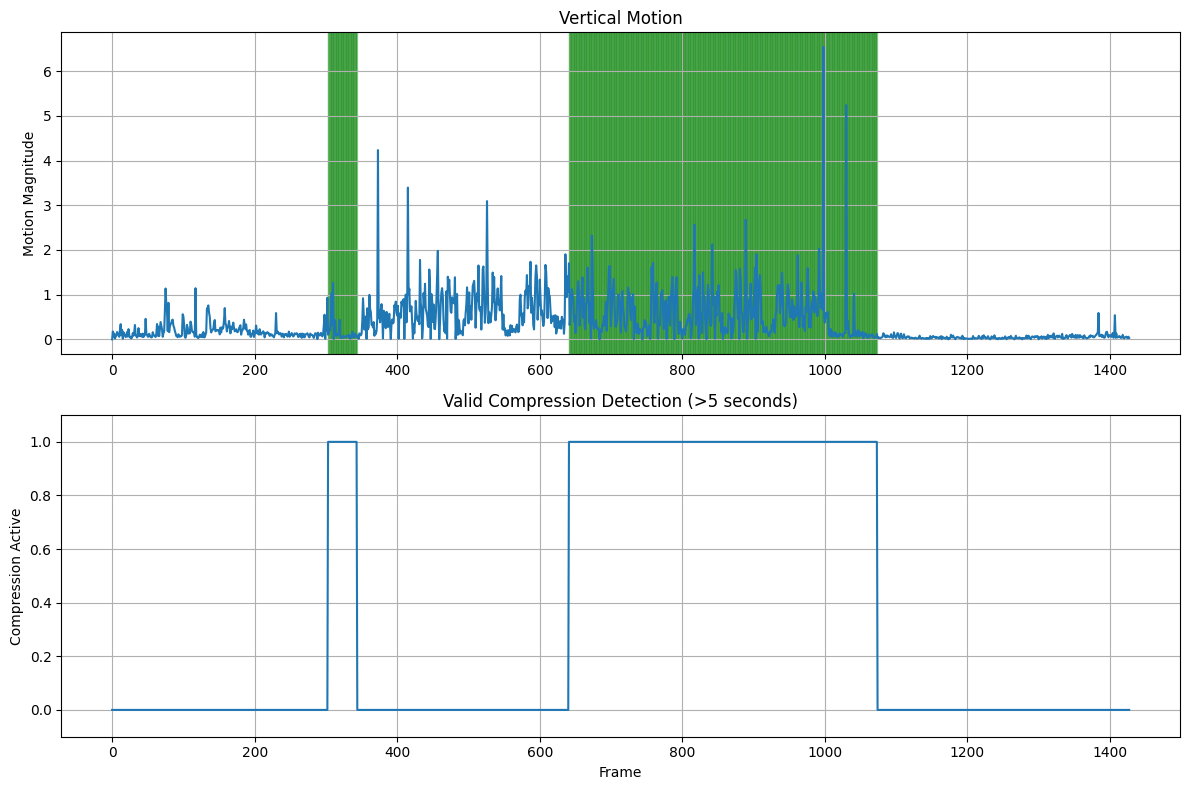

Plot saved to /content/drive/MyDrive/compression_analysis.png
Processing complete! Output saved to /content/drive/MyDrive/6.7930/Chest Compressions/output2.mp4


In [ ]:
# Main execution function for using files from Google Drive
def main_from_drive():
    # Paths to files in Google Drive
    model_weights_path = YOLO_WEIGHTS_PATH  # Update this path
    video_path = "/content/drive/MyDrive/6.7930/Chest Compressions/Yes/2025-04-17_12-11-39_chest_compression.mp4"  # Update this path
    output_path = "/content/drive/MyDrive/6.7930/Chest Compressions/output2.mp4"  # Output location

    print(f"Using model weights: {model_weights_path}")
    print(f"Processing video: {video_path}")
    print(f"Output will be saved to: {output_path}")

    # Check if files exist
    if not os.path.exists(model_weights_path):
        print(f"Error: Model weights file not found at {model_weights_path}")
        return

    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return

    # Initialize the detector
    detector = ChestCompressionDetector(
        model_weights_path=model_weights_path,
        compression_rate=90  # 90 compressions per minute as specified
    )

    # Process the video
    detector.process_video(
        video_path=video_path,
        output_path=output_path,
        display_in_notebook=True
    )

# Run the main function for Google Drive
if __name__ == "__main__":
    main_from_drive()

Using model weights: /content/drive/MyDrive/6.7930/best_yolo_weights_across_skin_colors.pt
Processing video: /content/drive/MyDrive/6.7930/Chest Compressions/Yes/2.25.25_sc3_cropped_chest_compression.mp4
Output will be saved to: /content/drive/MyDrive/6.7930/Chest Compressions/output3.mp4
Video dimensions: 1280x720, FPS: 29
Set FPS to 29, minimum compression duration: 290 frames



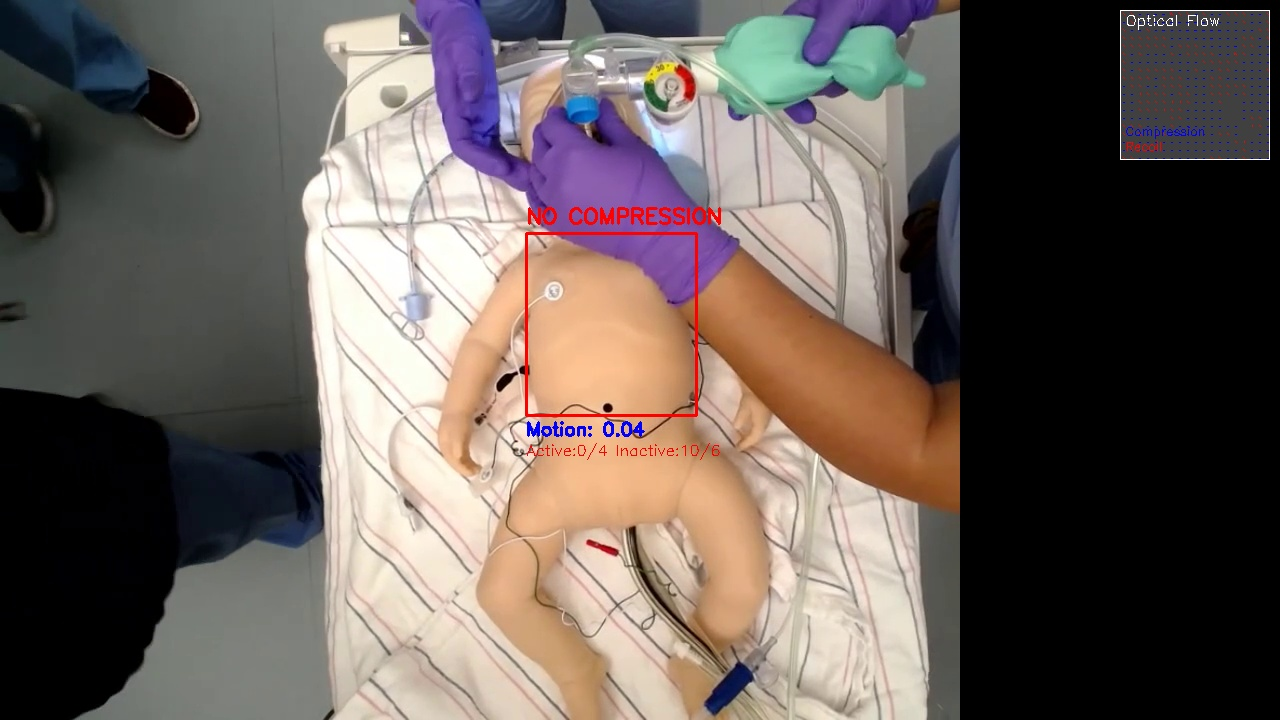

Total frames: 3643

0: 384x640 1 torso, 107.3ms
Speed: 5.2ms preprocess, 107.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 torso, 103.6ms
Speed: 1.8ms preprocess, 103.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Peaks: 5, Rate: 193.3 bpm, Consistency: 0.53, Rhythm: False

0: 384x640 1 torso, 95.1ms
Speed: 1.6ms preprocess, 95.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 torso, 104.9ms
Speed: 2.3ms preprocess, 104.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 torso, 93.6ms
Speed: 1.7ms preprocess, 93.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
Processed 100/3643 frames (2.7%)
Peaks: 3, Rate: 217.5 bpm, Consistency: 0.38, Rhythm: False
Processed 200/3643 frames (5.5%)

0: 384x640 1 torso, 98.6ms
Speed: 2.2ms preprocess, 98.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 torso, 92.4ms
Speed: 1.8m

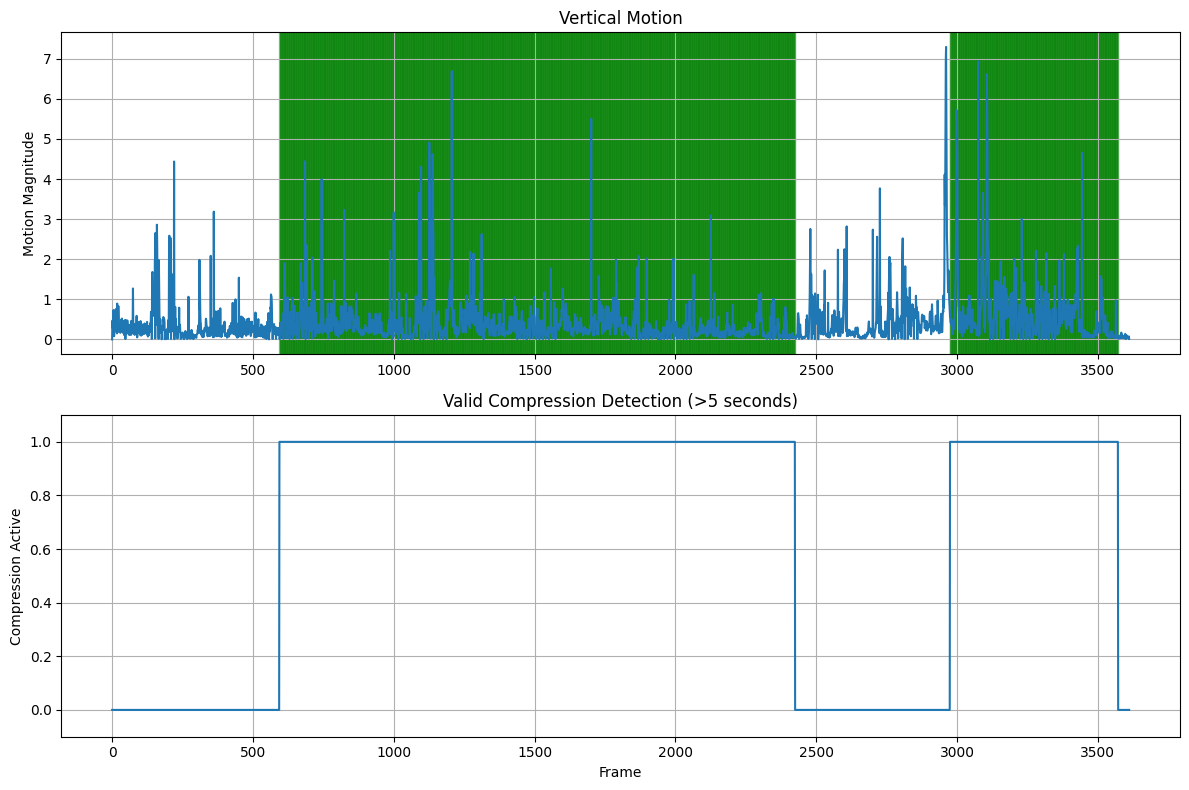

Plot saved to /content/drive/MyDrive/compression_analysis.png
Processing complete! Output saved to /content/drive/MyDrive/6.7930/Chest Compressions/output3.mp4


In [ ]:
# Main execution function for using files from Google Drive
def main_from_drive():
    # Paths to files in Google Drive
    model_weights_path = YOLO_WEIGHTS_PATH  # Update this path
    video_path = "/content/drive/MyDrive/6.7930/Chest Compressions/Yes/2.25.25_sc3_cropped_chest_compression.mp4"  # Update this path
    output_path = "/content/drive/MyDrive/6.7930/Chest Compressions/output3.mp4"  # Output location

    print(f"Using model weights: {model_weights_path}")
    print(f"Processing video: {video_path}")
    print(f"Output will be saved to: {output_path}")

    # Check if files exist
    if not os.path.exists(model_weights_path):
        print(f"Error: Model weights file not found at {model_weights_path}")
        return

    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return

    # Initialize the detector
    detector = ChestCompressionDetector(
        model_weights_path=model_weights_path,
        compression_rate=90  # 90 compressions per minute as specified
    )

    # Process the video
    detector.process_video(
        video_path=video_path,
        output_path=output_path,
        display_in_notebook=True
    )

# Run the main function for Google Drive
if __name__ == "__main__":
    main_from_drive()

Using model weights: /content/drive/MyDrive/6.7930/best_yolo_weights_across_skin_colors.pt
Processing video: /content/drive/MyDrive/6.7930/Chest Compressions/Yes/2025-04-17_17-37-18_chest_compression.mp4
Output will be saved to: /content/drive/MyDrive/6.7930/Chest Compressions/output4.mp4
Video dimensions: 1280x720, FPS: 29
Set FPS to 29, minimum compression duration: 290 frames



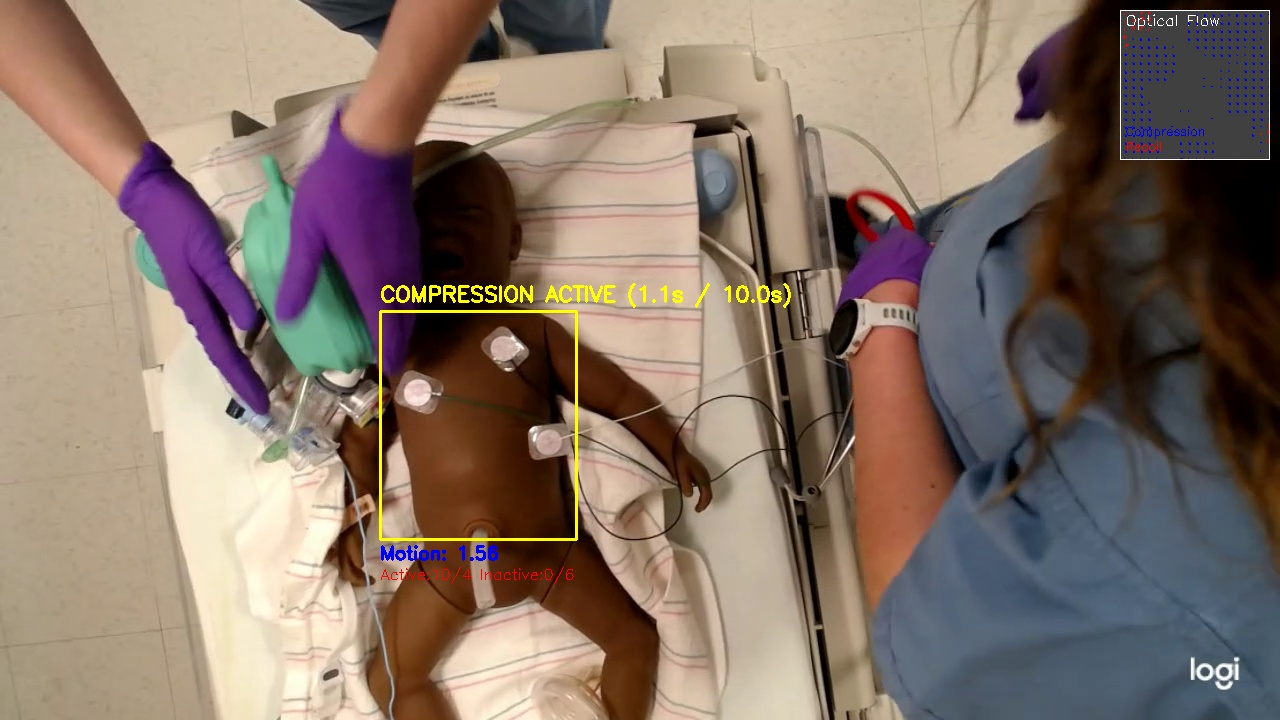

Total frames: 1384

0: 384x640 1 torso, 111.0ms
Speed: 2.8ms preprocess, 111.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 torso, 96.8ms
Speed: 1.8ms preprocess, 96.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 torsos, 125.8ms
Speed: 1.8ms preprocess, 125.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
Peaks: 3, Rate: 105.5 bpm, Consistency: 0.15, Rhythm: False

0: 384x640 1 torso, 133.3ms
Speed: 1.9ms preprocess, 133.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 torso, 123.5ms
Speed: 1.8ms preprocess, 123.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
Processed 100/1384 frames (7.2%)

0: 384x640 1 torso, 120.9ms
Speed: 1.9ms preprocess, 120.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 torso, 121.6ms
Speed: 1.6ms preprocess, 121.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


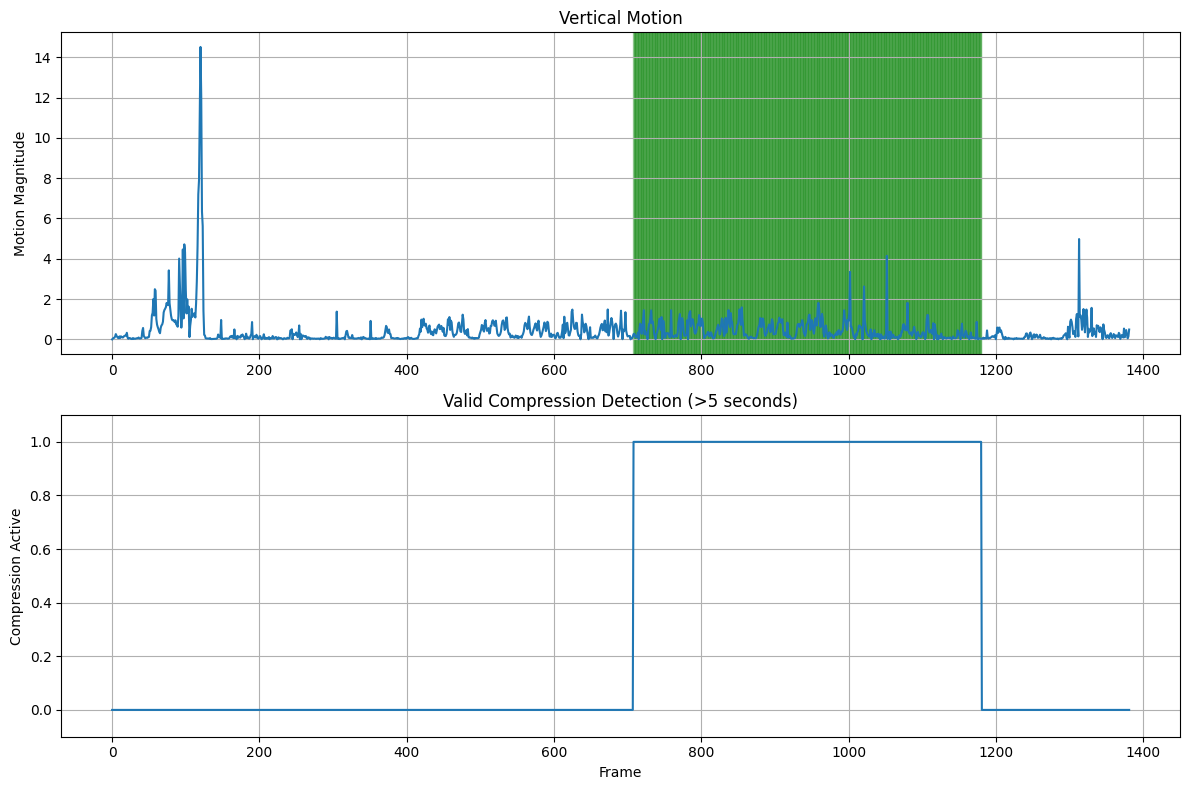

Plot saved to /content/drive/MyDrive/compression_analysis.png
Processing complete! Output saved to /content/drive/MyDrive/6.7930/Chest Compressions/output4.mp4


In [ ]:
# Main execution function for using files from Google Drive
def main_from_drive():
    # Paths to files in Google Drive
    model_weights_path = YOLO_WEIGHTS_PATH  # Update this path
    video_path = "/content/drive/MyDrive/6.7930/Chest Compressions/Yes/2025-04-17_17-37-18_chest_compression.mp4"  # Update this path
    output_path = "/content/drive/MyDrive/6.7930/Chest Compressions/output4.mp4"  # Output location

    print(f"Using model weights: {model_weights_path}")
    print(f"Processing video: {video_path}")
    print(f"Output will be saved to: {output_path}")

    # Check if files exist
    if not os.path.exists(model_weights_path):
        print(f"Error: Model weights file not found at {model_weights_path}")
        return

    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return

    # Initialize the detector
    detector = ChestCompressionDetector(
        model_weights_path=model_weights_path,
        compression_rate=90  # 90 compressions per minute as specified
    )

    # Process the video
    detector.process_video(
        video_path=video_path,
        output_path=output_path,
        display_in_notebook=True
    )

# Run the main function for Google Drive
if __name__ == "__main__":
    main_from_drive()

In [ ]:
# Main execution function for using files from Google Drive
def main_from_drive():
    # Paths to files in Google Drive
    model_weights_path = '/content/drive/MyDrive/yolov8_weights.pt'  # UPDATE THIS PATH
    video_path = '/content/drive/MyDrive/your_video.mp4'  # UPDATE THIS PATH
    output_path = '/content/drive/MyDrive/output_detection.mp4'  # Output location

    print(f"Using model weights: {model_weights_path}")
    print(f"Processing video: {video_path}")
    print(f"Output will be saved to: {output_path}")

    # Check if files exist
    if not os.path.exists(model_weights_path):
        print(f"Error: Model weights file not found at {model_weights_path}")
        return

    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        return

    # Initialize the detector
    detector = ChestCompressionDetector(
        model_weights_path=model_weights_path,
        compression_rate=90  # 90 compressions per minute as specified
    )

    # Process the video
    detector.process_video(
        video_path=video_path,
        output_path=output_path,
        display_in_notebook=True
    )

# Run the main function for Google Drive
if __name__ == "__main__":
    main_from_drive()